In [1]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import pandas as pd
import numpy as np
import os

## Load data

In [3]:
data = pd.read_pickle('../data/data_proton_neutron_photonsum_20_padding.pkl')
print('Loaded: ',  data.shape)
data_cond = pd.read_pickle('../data/data_cond_photonsum_20.pkl')
print('Loaded cond: ',  data_cond.shape)

Loaded:  (32951, 56, 44, 2)
Loaded cond:  (32951, 12)


In [4]:
data_cond.drop(columns=['proton_photon_sum', 'neutron_photon_sum'], inplace=True)

In [5]:
data_cond.columns, len(data_cond.columns)

(Index(['Pdg', 'Energy', 'Vx', 'Vy', 'Vz', 'Px', 'Py', 'Pz', 'mass', 'charge'], dtype='object'),
 10)

### Preprocess data

In [6]:
data = np.float32(np.log(data+1))

In [7]:
# Credits: majerzemilia

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn import datasets, linear_model, decomposition, manifold, preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from tensorflow.keras import layers
import pickle
import time
from numpy import load
import pickle
import argparse

import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

from tensorflow.compat.v1.keras.layers import Input, Dense, LeakyReLU, Conv2D, MaxPooling2D, UpSampling2D,  Concatenate, Conv2DTranspose
from tensorflow.compat.v1.keras.models import Model
from tensorflow.compat.v1.keras.layers import Dense, Reshape, Flatten
from tensorflow.compat.v1.keras.layers import Dropout,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import mse, binary_crossentropy, logcosh
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from scipy.stats import wasserstein_distance
import pandas as pd
from utils.utils import sum_channels_parallel_ as sum_channels_parallel
from sklearn.metrics import mean_absolute_error
from datetime import datetime

2.10.1


In [8]:
DATE_STR = datetime.now().strftime("%d_%m_%Y_%H_%M")

NAME = "model_"+DATE_STR

EXPERIMENT_NAME = f"{DATE_STR}_MIN_70"

print(DATE_STR, NAME, EXPERIMENT_NAME)

02_03_2023_23_39 model_02_03_2023_23_39 02_03_2023_23_39_MIN_70


In [9]:
def create_dir(path):
    isExist = os.path.exists(path)
    if not isExist:
        os.makedirs(path)

In [10]:
create_dir(os.path.join("../models/", EXPERIMENT_NAME))

def save_scales(model_name, scaler_means, scaler_scales):
    out_fnm = f"{model_name}_scales.txt"
    res = "#means"
    for mean_ in scaler_means:
        res += "\n" + str(mean_)
    res += "\n\n#scales"
    for scale_ in scaler_scales:
        res += "\n" + str(scale_)
    with open(f"../models/{EXPERIMENT_NAME}/{out_fnm}", mode="w") as f:
        f.write(res)

In [11]:
# wyrzucić regularyzację z lossu

# train/test split
x_train, x_test, y_train, y_test, = train_test_split(data, data_cond, test_size=0.2, shuffle=False)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

#scale cond data
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
print("cond max", y_train.max(), "min", y_train.min())

#save scales
save_scales("Proton", scaler.mean_, scaler.scale_)

# make tf datasets
dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size=128)
dataset_cond = tf.data.Dataset.from_tensor_slices(y_train).batch(batch_size=128)
dataset_with_cond = tf.data.Dataset.zip((dataset,dataset_cond)).shuffle(12800)

val_dataset = tf.data.Dataset.from_tensor_slices(x_test).batch(batch_size=128)
val_dataset_cond = tf.data.Dataset.from_tensor_slices(y_test).batch(batch_size=128)
val_dataset_with_cond = tf.data.Dataset.zip((val_dataset,val_dataset_cond)).shuffle(12800)

(26360, 56, 44, 2) (6591, 56, 44, 2) (26360, 10) (6591, 10)
cond max 39.35081060792358 min -77.36589109271856


In [12]:
############################ Define Models ############################
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


latent_dim = 10
cond_dim = 10
poz_dim = 6


############################ encoder ############################

input_img = Input(shape=[56, 44, 2],name='input_img_neutron_proton')
input_cond = Input(shape=cond_dim,name='input_cond')

x = Conv2D(32, kernel_size=4, strides=2, padding='same')(input_img)
x = Conv2D(64, kernel_size=4, strides=2, padding='same')(x)
x = Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)
x = Flatten()(x)

# merge with condition
x = Concatenate()([x, input_cond])
x = Dense(latent_dim*2, activation='relu')(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model([input_img, input_cond], [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img_neutron_proton (Inpu  [(None, 56, 44, 2)]  0          []                               
 tLayer)                                                                                          
                                                                                                  
 conv2d (Conv2D)                (None, 28, 22, 32)   1056        ['input_img_neutron_proton[0][0]'
                                                                 ]                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 11, 64)   32832       ['conv2d[0][0]']                 
                                                                                            

In [13]:
############################ decoder ############################

x = Input(shape=(latent_dim,))
cond = Input(shape=(cond_dim,))
inputs = Concatenate(axis=1)([x, cond])

g = Dense(7*4*128)(inputs)
g = Reshape((7,4,128))(g)

g = UpSampling2D()(g)
g = Conv2D(128, kernel_size=4, padding='same')(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0)(g)

g = UpSampling2D()(g)
g = Conv2D(64, kernel_size=4, padding='same')(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0)(g)

g = UpSampling2D(2)(g) # added an upsampling layer for the second dimension
g = Conv2D(32, kernel_size=4, padding='same')(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0)(g)

g = UpSampling2D(size=(1,2))(g)
outputs = Conv2D(2, kernel_size=(1, 21) ,activation='relu')(g) # set the number of filters to 2

generator = Model([x, cond], outputs, name='generator')
generator.summary()

# define losses
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
d_acc_r = keras.metrics.BinaryAccuracy(name="d_acc_r", threshold=0.5)
d_acc_f = keras.metrics.BinaryAccuracy(name="d_acc_r", threshold=0.5)
g_acc = keras.metrics.BinaryAccuracy(name="g_acc_g", threshold=0.5)

# define optimizer
vae_optimizer = tf.keras.optimizers.RMSprop(1e-4)

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 20)           0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 3584)         75264       ['concatenate_1[0][0]']  

In [14]:
# trainin params
EPOCHS = 100
noise_dim = 10
num_examples_to_generate = 16

# Seed to reuse for generating samples for comparison during training
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed_cond = y_test[:num_examples_to_generate]


### function to calculate ws distance between original and generated channels
org=np.exp(x_test)-1
ch_org = org.reshape(-1,56,44)
ch_org = pd.DataFrame(sum_channels_parallel(ch_org)).values
del org

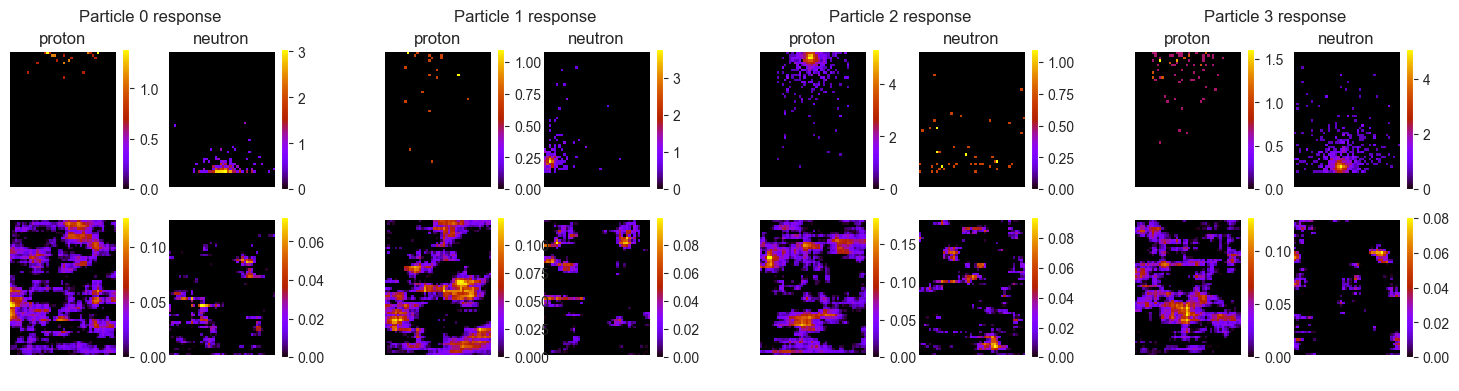

100 [Total loss: 105.55] [Recon_loss: 100.03] [KL loss: 7.89]
200 [Total loss: 93.84] [Recon_loss: 87.04] [KL loss: 9.71]


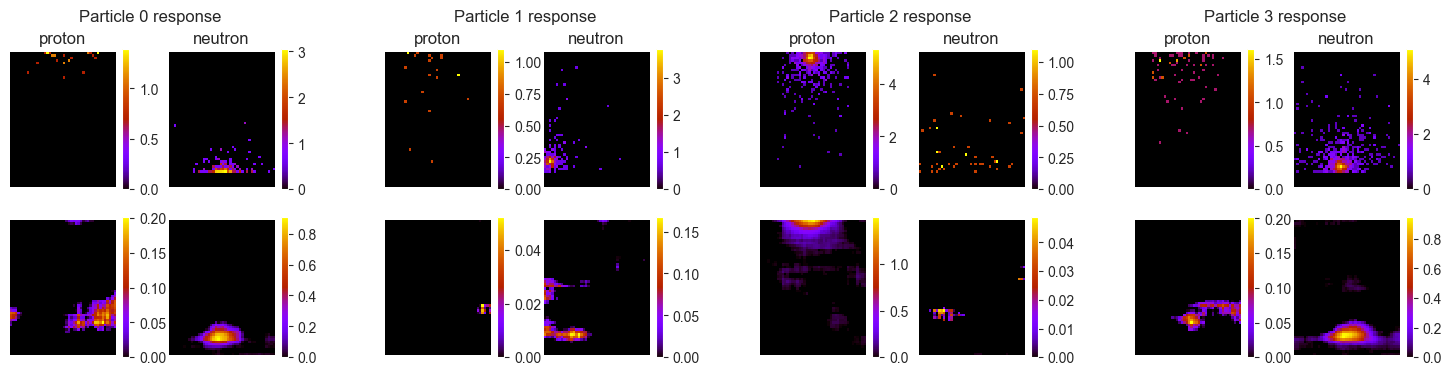

206/206 [==============================] - 3s 12ms/step
ws mean 81.21 ch1 68.96 ch2 48.57 ch3 32.42 ch4 17.28 ch5 238.84 Time for epoch 1 is 37.474124908447266 sec
300 [Total loss: 95.98] [Recon_loss: 89.85] [KL loss: 8.76]
400 [Total loss: 95.61] [Recon_loss: 89.44] [KL loss: 8.83]


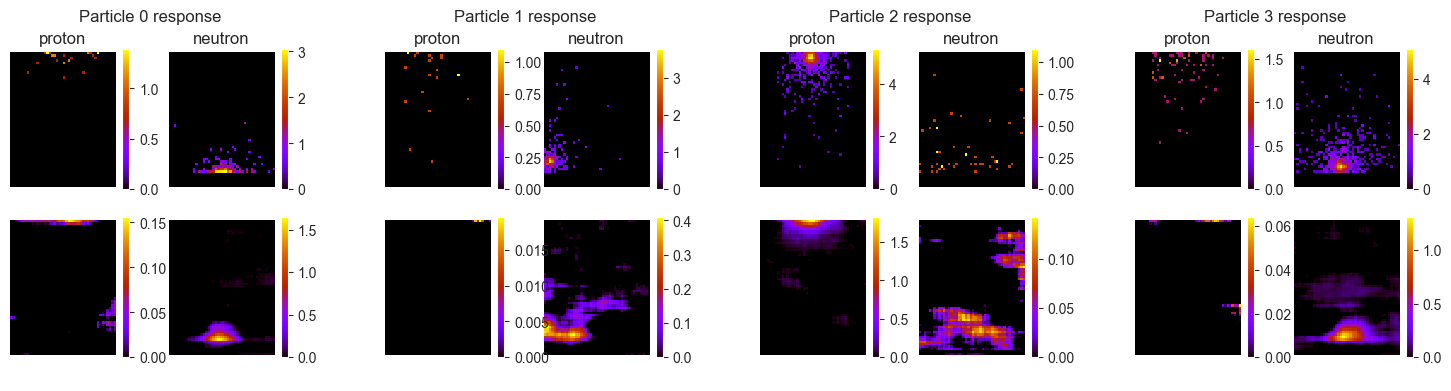

206/206 [==============================] - 3s 13ms/step
ws mean 72.52 ch1 62.11 ch2 45.06 ch3 27.46 ch4 14.99 ch5 212.96 Time for epoch 2 is 28.071345329284668 sec
500 [Total loss: 86.96] [Recon_loss: 81.61] [KL loss: 7.64]
600 [Total loss: 85.24] [Recon_loss: 80.04] [KL loss: 7.43]


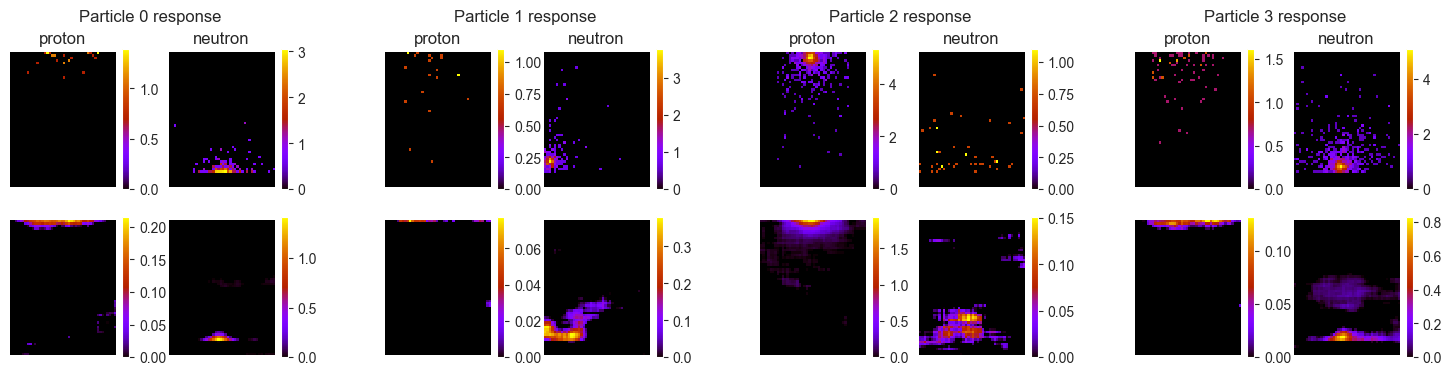

206/206 [==============================] - 3s 13ms/step
ws mean 79.16 ch1 68.26 ch2 45.68 ch3 34.54 ch4 17.59 ch5 229.72 Time for epoch 3 is 28.37407159805298 sec
700 [Total loss: 83.53] [Recon_loss: 78.20] [KL loss: 7.62]
800 [Total loss: 81.39] [Recon_loss: 76.28] [KL loss: 7.31]


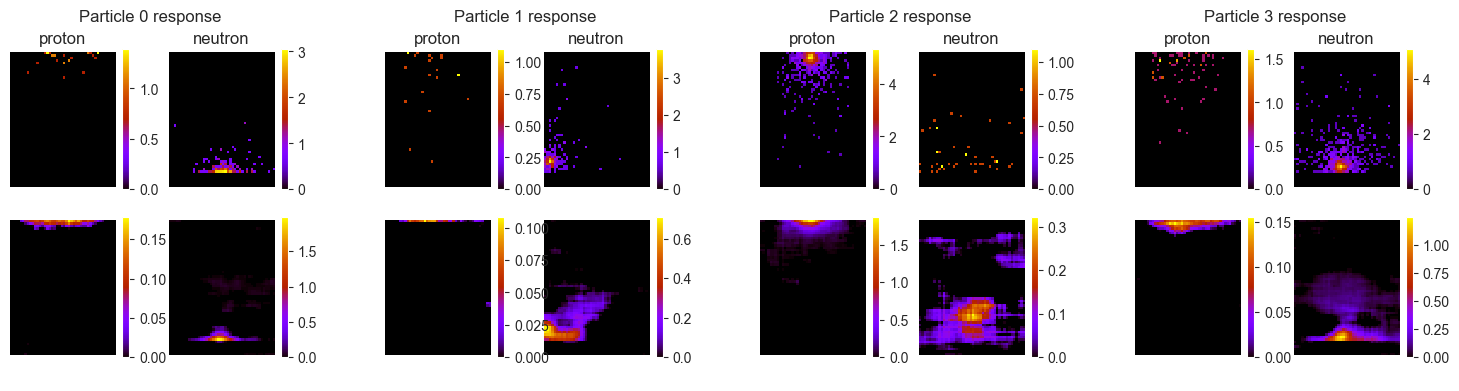

206/206 [==============================] - 3s 13ms/step
ws mean 71.45 ch1 61.68 ch2 43.34 ch3 28.82 ch4 14.87 ch5 208.53 Time for epoch 4 is 29.00921058654785 sec
900 [Total loss: 81.43] [Recon_loss: 76.61] [KL loss: 6.88]
1000 [Total loss: 82.37] [Recon_loss: 77.54] [KL loss: 6.91]


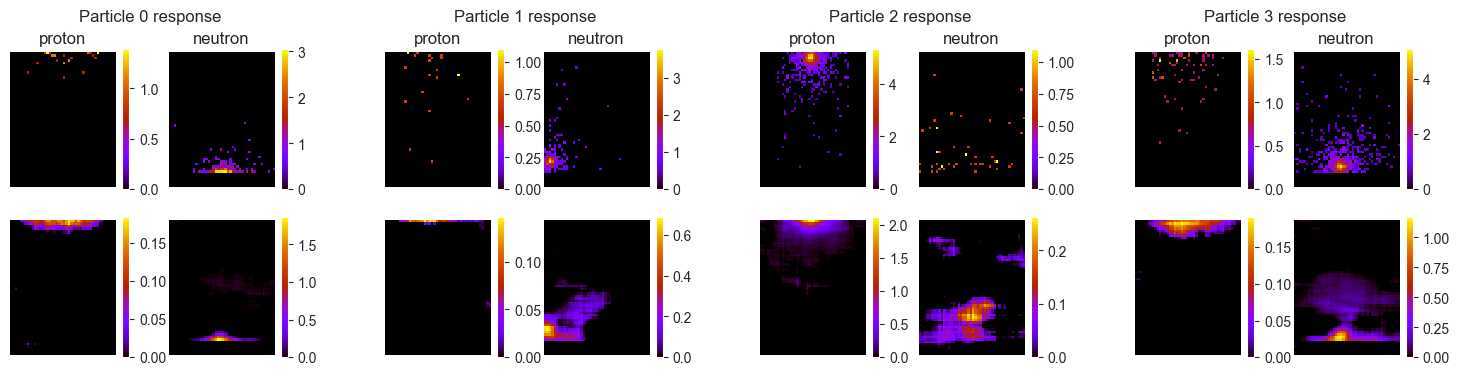

206/206 [==============================] - 3s 13ms/step
ws mean 69.58 ch1 62.10 ch2 39.38 ch3 30.18 ch4 15.42 ch5 200.83 Time for epoch 5 is 33.552424907684326 sec
1100 [Total loss: 82.22] [Recon_loss: 77.76] [KL loss: 6.38]
1200 [Total loss: 80.64] [Recon_loss: 76.34] [KL loss: 6.14]


206/206 [==============================] - 2s 11ms/step
ws mean 66.13 ch1 57.87 ch2 41.02 ch3 26.38 ch4 14.16 ch5 191.20 Time for epoch 6 is 31.986549377441406 sec
1300 [Total loss: 82.32] [Recon_loss: 78.13] [KL loss: 6.00]
1400 [Total loss: 80.78] [Recon_loss: 76.85] [KL loss: 5.61]


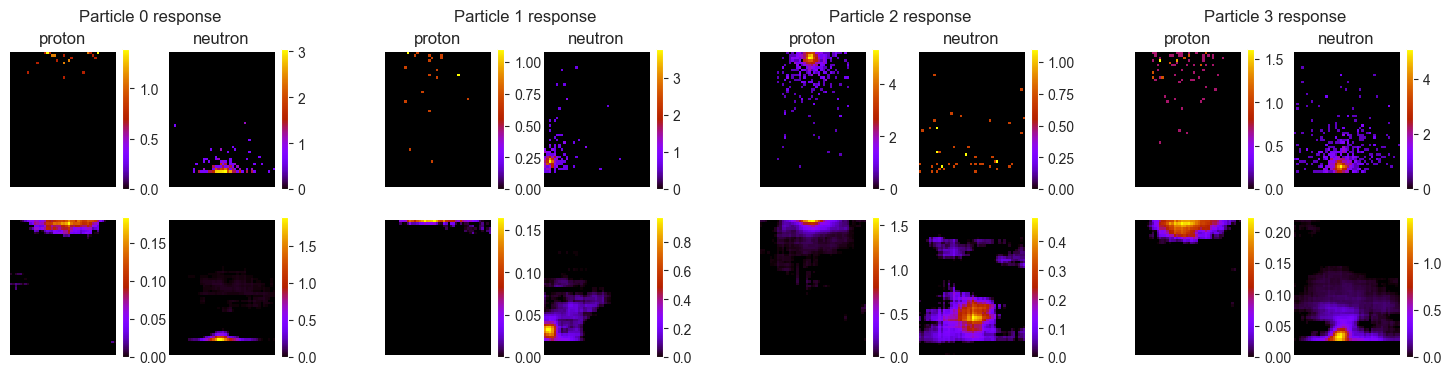

206/206 [==============================] - 2s 11ms/step
ws mean 69.80 ch1 60.78 ch2 41.22 ch3 29.26 ch4 15.17 ch5 202.56 Time for epoch 7 is 32.71335244178772 sec
1500 [Total loss: 80.85] [Recon_loss: 77.54] [KL loss: 4.72]
1600 [Total loss: 79.40] [Recon_loss: 76.05] [KL loss: 4.79]


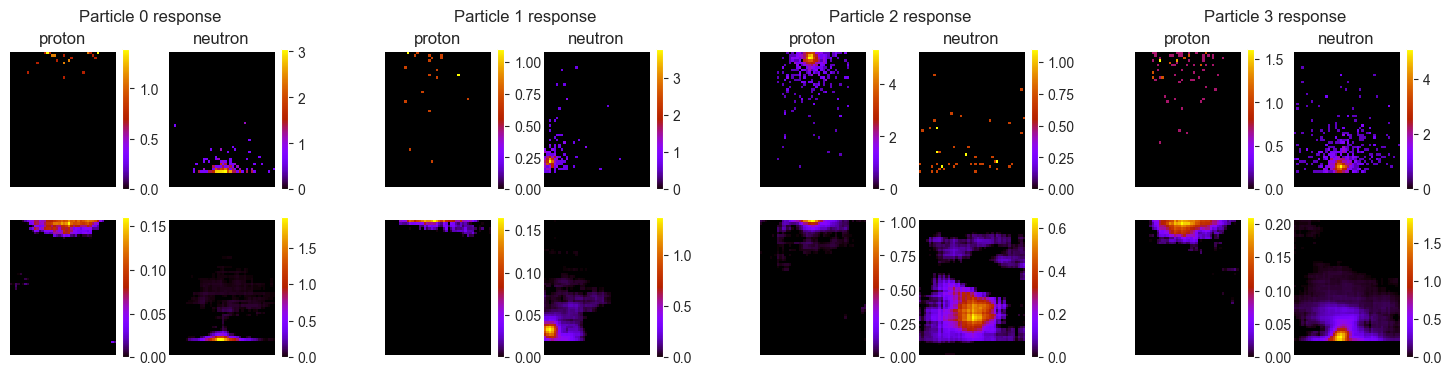

206/206 [==============================] - 2s 11ms/step
ws mean 64.87 ch1 55.92 ch2 39.38 ch3 26.13 ch4 13.91 ch5 189.01 Time for epoch 8 is 33.06334376335144 sec
1700 [Total loss: 78.35] [Recon_loss: 75.11] [KL loss: 4.63]
1800 [Total loss: 78.17] [Recon_loss: 75.19] [KL loss: 4.26]


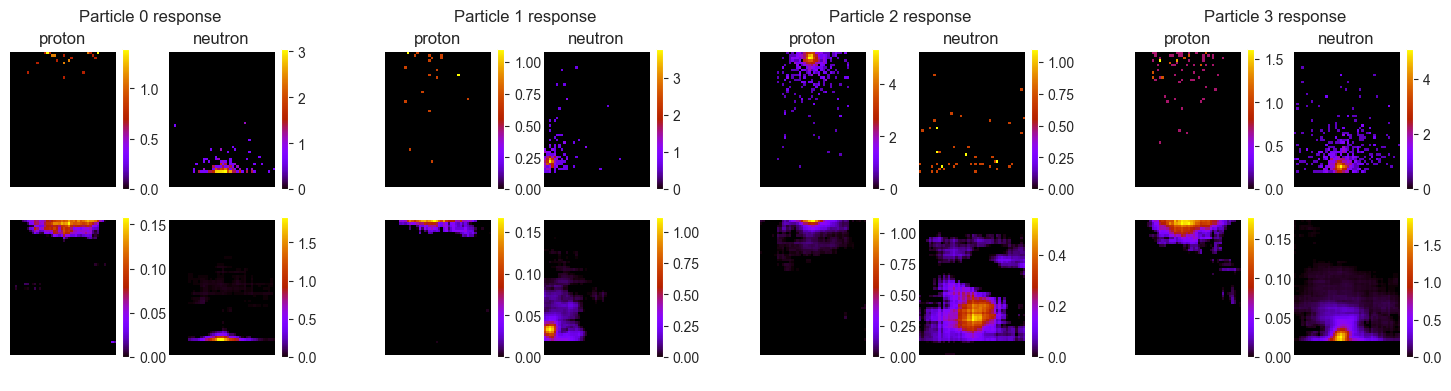

206/206 [==============================] - 2s 11ms/step
ws mean 65.07 ch1 55.64 ch2 39.54 ch3 27.23 ch4 14.32 ch5 188.62 Time for epoch 9 is 32.75160074234009 sec
1900 [Total loss: 77.52] [Recon_loss: 74.51] [KL loss: 4.30]
2000 [Total loss: 78.60] [Recon_loss: 75.60] [KL loss: 4.29]


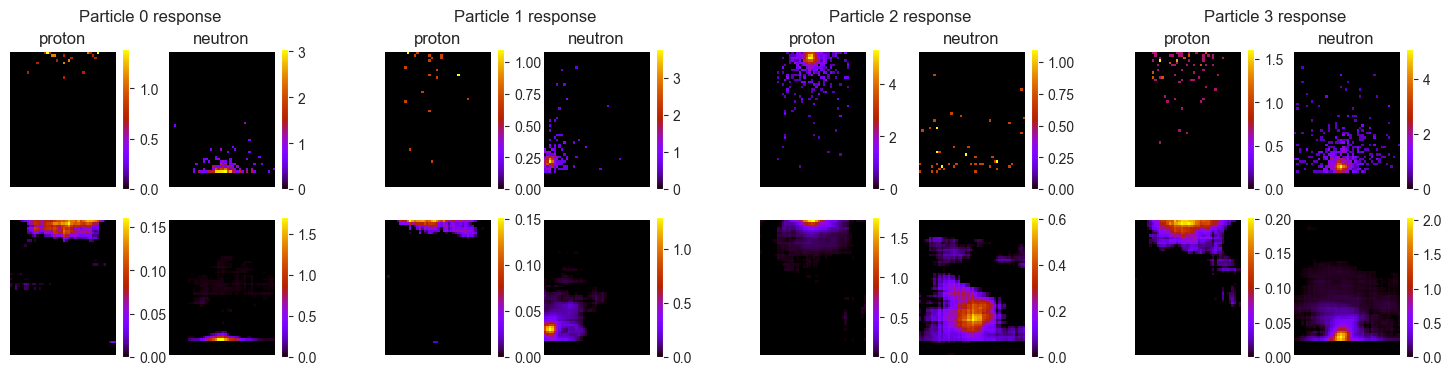

206/206 [==============================] - 2s 11ms/step
ws mean 56.57 ch1 51.07 ch2 31.25 ch3 24.73 ch4 12.39 ch5 163.40 Time for epoch 10 is 38.619187116622925 sec
2100 [Total loss: 76.42] [Recon_loss: 73.82] [KL loss: 3.73]
2200 [Total loss: 76.20] [Recon_loss: 73.35] [KL loss: 4.08]


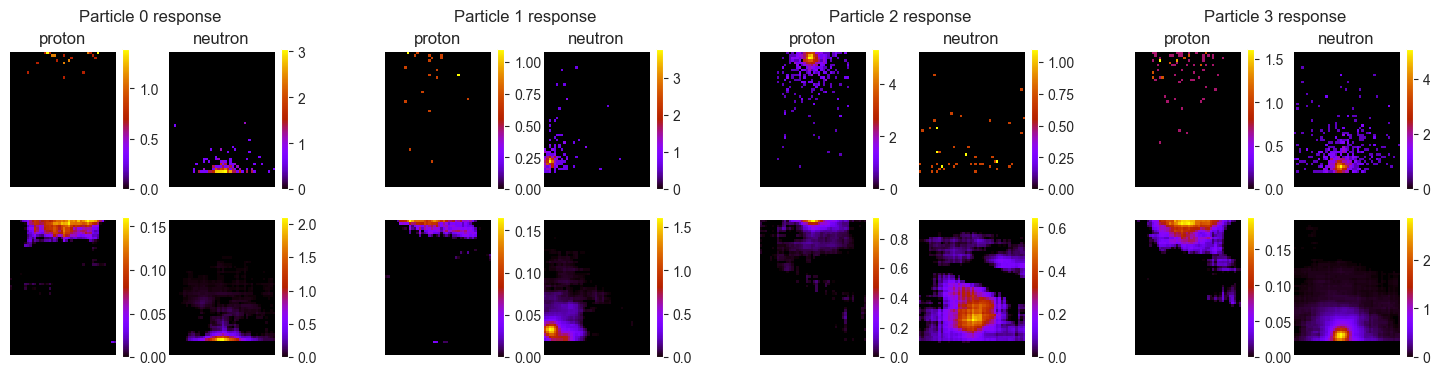

206/206 [==============================] - 2s 11ms/step
ws mean 52.73 ch1 44.56 ch2 33.47 ch3 21.00 ch4 10.89 ch5 153.74 Time for epoch 11 is 36.576056480407715 sec
2300 [Total loss: 75.99] [Recon_loss: 73.42] [KL loss: 3.67]
2400 [Total loss: 79.54] [Recon_loss: 76.88] [KL loss: 3.80]


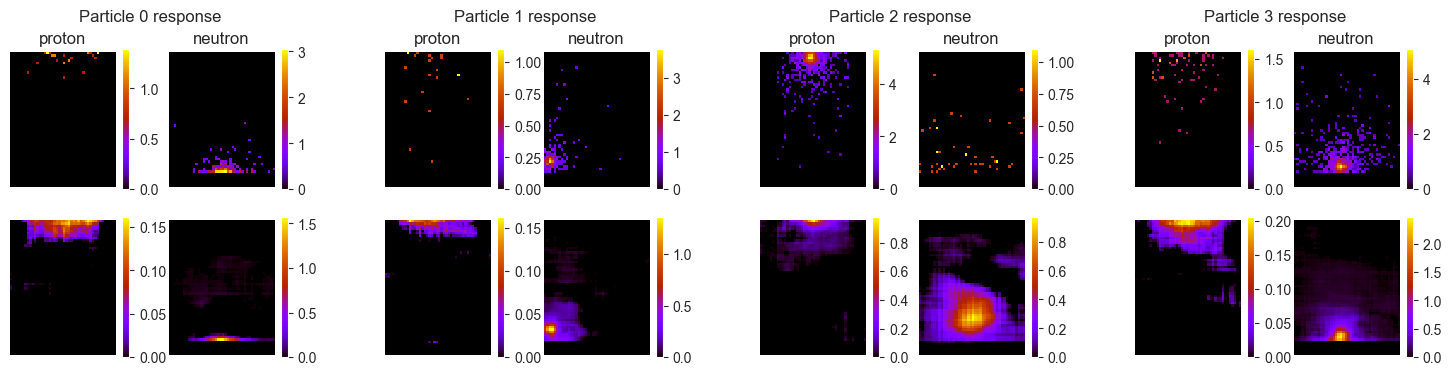

206/206 [==============================] - 2s 11ms/step
ws mean 57.25 ch1 50.10 ch2 33.50 ch3 24.76 ch4 11.92 ch5 165.98 Time for epoch 12 is 34.83346915245056 sec
2500 [Total loss: 73.44] [Recon_loss: 71.09] [KL loss: 3.37]
2600 [Total loss: 77.66] [Recon_loss: 75.67] [KL loss: 2.85]


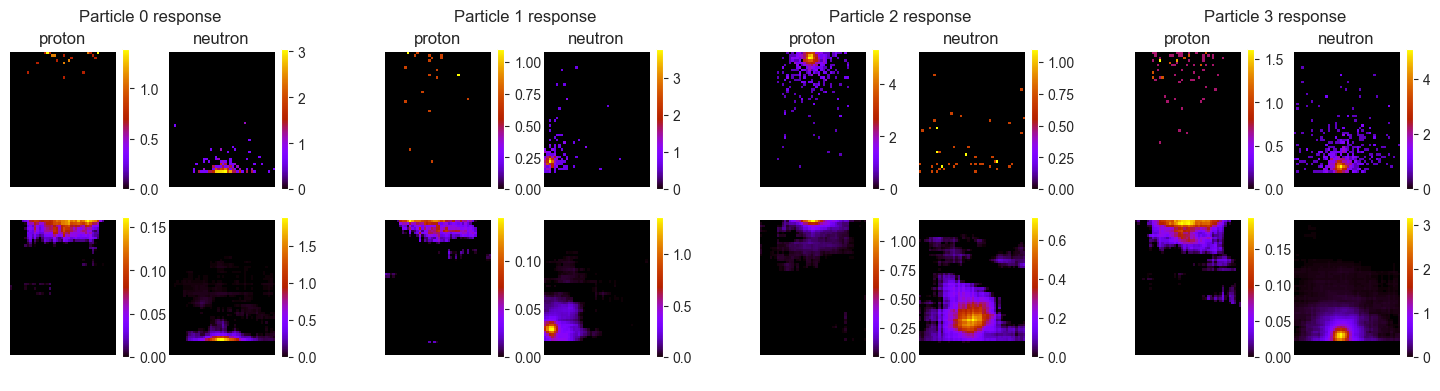

206/206 [==============================] - 2s 11ms/step
ws mean 52.62 ch1 46.27 ch2 31.55 ch3 21.69 ch4 11.85 ch5 151.73 Time for epoch 13 is 35.399919509887695 sec
2700 [Total loss: 73.93] [Recon_loss: 71.95] [KL loss: 2.82]
2800 [Total loss: 72.09] [Recon_loss: 70.28] [KL loss: 2.58]


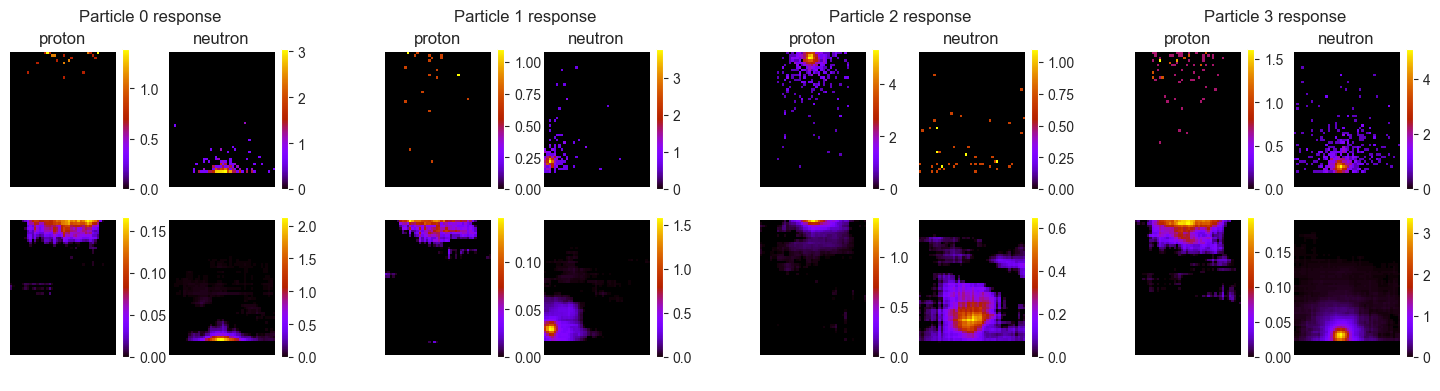

206/206 [==============================] - 2s 11ms/step
ws mean 44.33 ch1 37.99 ch2 28.13 ch3 18.46 ch4 10.22 ch5 126.83 Time for epoch 14 is 35.37948822975159 sec
2900 [Total loss: 77.21] [Recon_loss: 75.13] [KL loss: 2.97]
3000 [Total loss: 74.90] [Recon_loss: 73.33] [KL loss: 2.24]


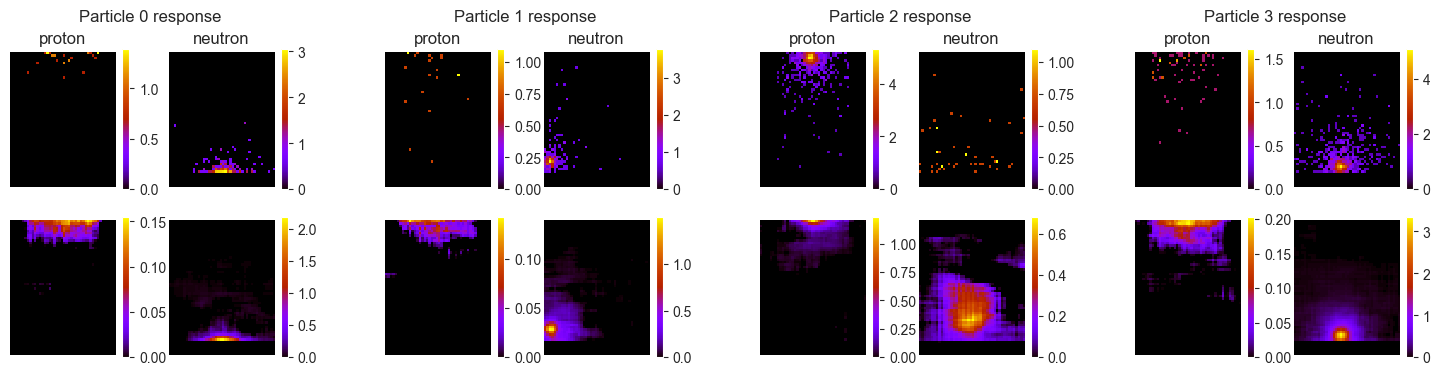

206/206 [==============================] - 2s 11ms/step
ws mean 56.02 ch1 48.36 ch2 33.66 ch3 23.80 ch4 12.59 ch5 161.71 Time for epoch 15 is 40.65858197212219 sec
3100 [Total loss: 78.62] [Recon_loss: 76.57] [KL loss: 2.92]
3200 [Total loss: 73.23] [Recon_loss: 71.31] [KL loss: 2.75]


206/206 [==============================] - 2s 11ms/step
ws mean 46.12 ch1 37.48 ch2 30.16 ch3 17.43 ch4 10.29 ch5 135.23 Time for epoch 16 is 39.05231475830078 sec
3300 [Total loss: 77.90] [Recon_loss: 76.07] [KL loss: 2.61]
3400 [Total loss: 74.59] [Recon_loss: 72.70] [KL loss: 2.70]
3500 [Total loss: 80.27] [Recon_loss: 79.00] [KL loss: 1.82]


206/206 [==============================] - 2s 11ms/step
ws mean 37.72 ch1 29.98 ch2 25.99 ch3 15.38 ch4 9.18 ch5 108.10 Time for epoch 17 is 39.480624198913574 sec
3600 [Total loss: 71.29] [Recon_loss: 69.84] [KL loss: 2.08]
3700 [Total loss: 74.14] [Recon_loss: 72.58] [KL loss: 2.23]


206/206 [==============================] - 2s 11ms/step
ws mean 51.04 ch1 47.87 ch2 29.47 ch3 21.84 ch4 11.12 ch5 144.90 Time for epoch 18 is 38.66766357421875 sec
3800 [Total loss: 75.01] [Recon_loss: 73.17] [KL loss: 2.62]
3900 [Total loss: 74.78] [Recon_loss: 73.19] [KL loss: 2.28]


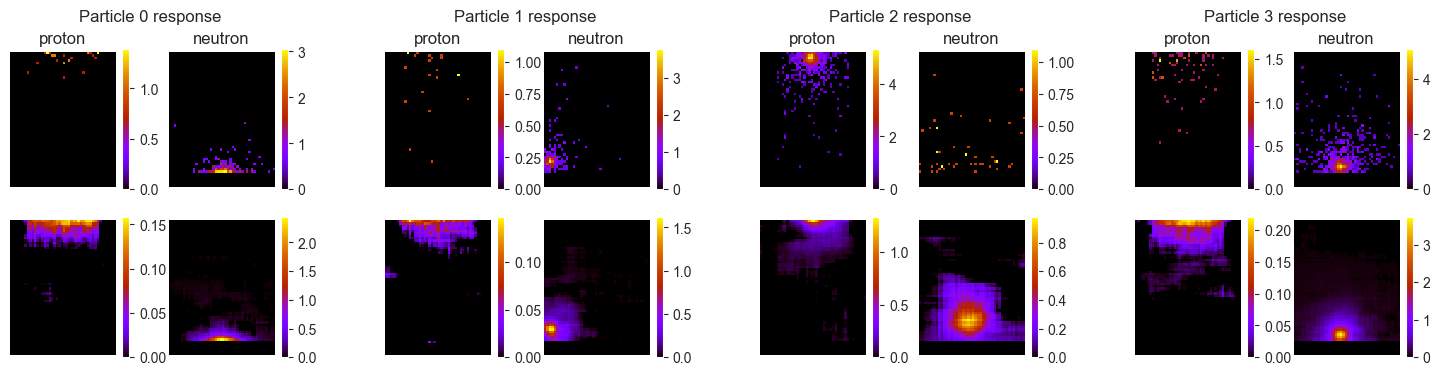

206/206 [==============================] - 2s 11ms/step
ws mean 41.06 ch1 34.25 ch2 27.81 ch3 17.17 ch4 9.88 ch5 116.20 Time for epoch 19 is 39.08813452720642 sec
4000 [Total loss: 70.63] [Recon_loss: 69.06] [KL loss: 2.25]


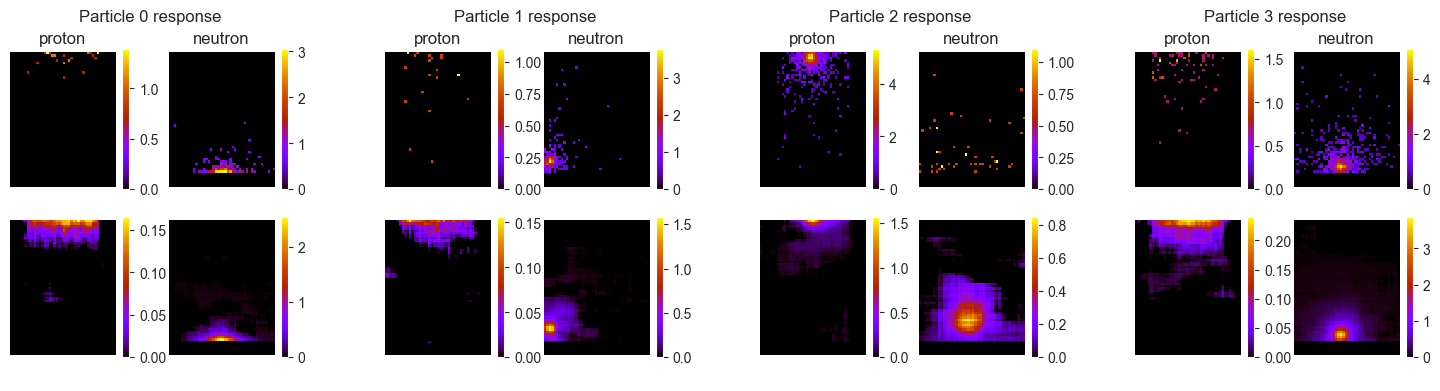

4100 [Total loss: 74.10] [Recon_loss: 72.94] [KL loss: 1.66]


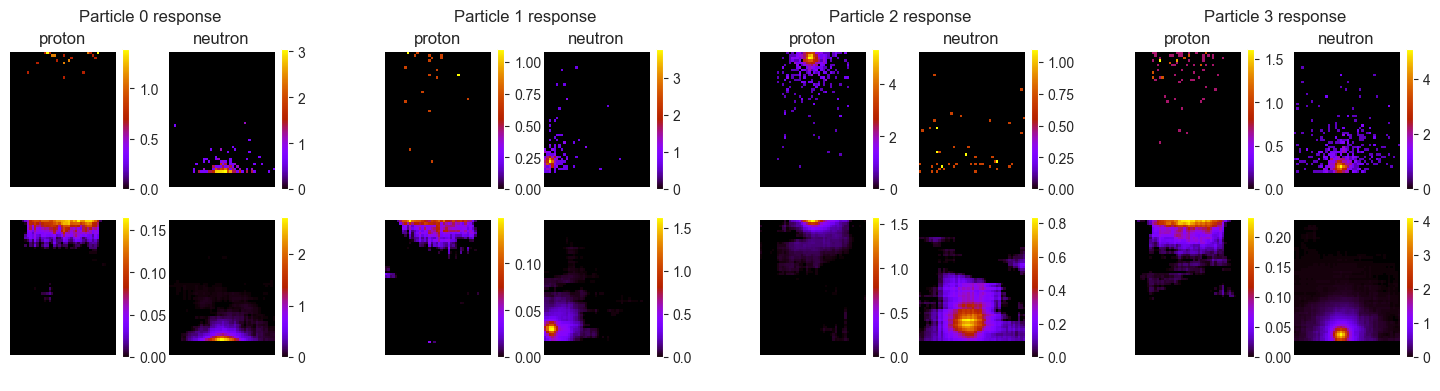

206/206 [==============================] - 2s 11ms/step
ws mean 34.87 ch1 27.01 ch2 25.09 ch3 14.42 ch4 8.91 ch5 98.94 Time for epoch 20 is 44.967838525772095 sec
4200 [Total loss: 77.49] [Recon_loss: 75.96] [KL loss: 2.18]
4300 [Total loss: 74.64] [Recon_loss: 73.42] [KL loss: 1.74]


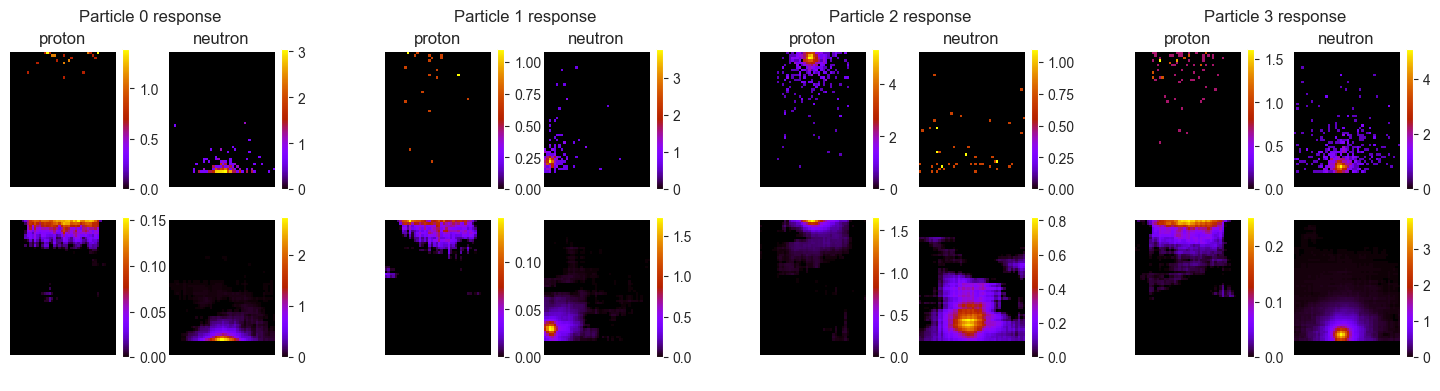

206/206 [==============================] - 2s 11ms/step
ws mean 36.12 ch1 28.37 ch2 25.10 ch3 13.12 ch4 8.59 ch5 105.44 Time for epoch 21 is 44.793676137924194 sec
4400 [Total loss: 76.73] [Recon_loss: 75.29] [KL loss: 2.06]
4500 [Total loss: 75.15] [Recon_loss: 73.67] [KL loss: 2.12]


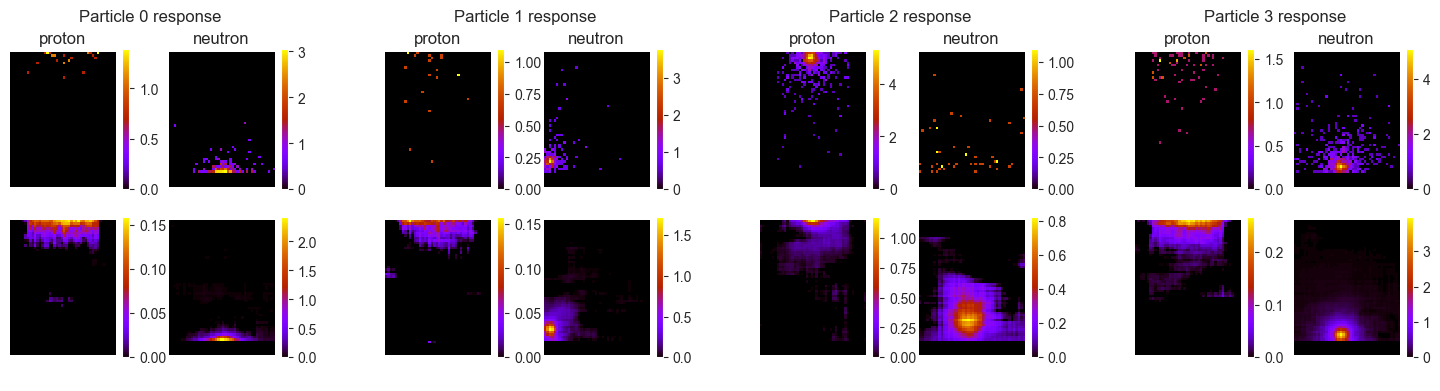

206/206 [==============================] - 2s 11ms/step
ws mean 40.42 ch1 34.10 ch2 27.32 ch3 17.62 ch4 9.85 ch5 113.22 Time for epoch 22 is 42.72811484336853 sec
4600 [Total loss: 72.63] [Recon_loss: 71.59] [KL loss: 1.48]
4700 [Total loss: 75.43] [Recon_loss: 73.98] [KL loss: 2.07]


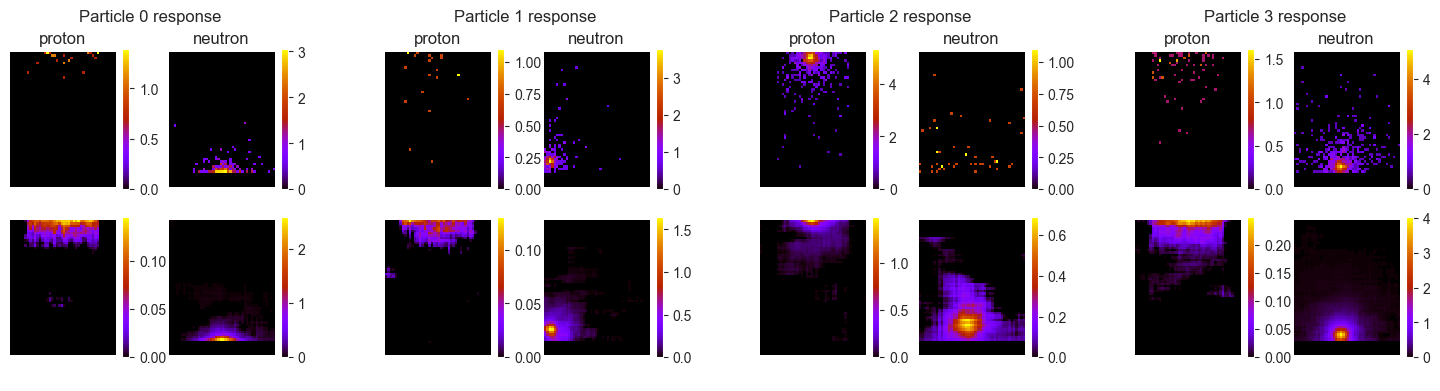

206/206 [==============================] - 2s 11ms/step
ws mean 44.58 ch1 36.34 ch2 30.06 ch3 18.89 ch4 10.93 ch5 126.67 Time for epoch 23 is 43.28189539909363 sec
4800 [Total loss: 75.26] [Recon_loss: 74.08] [KL loss: 1.68]
4900 [Total loss: 72.17] [Recon_loss: 70.65] [KL loss: 2.18]


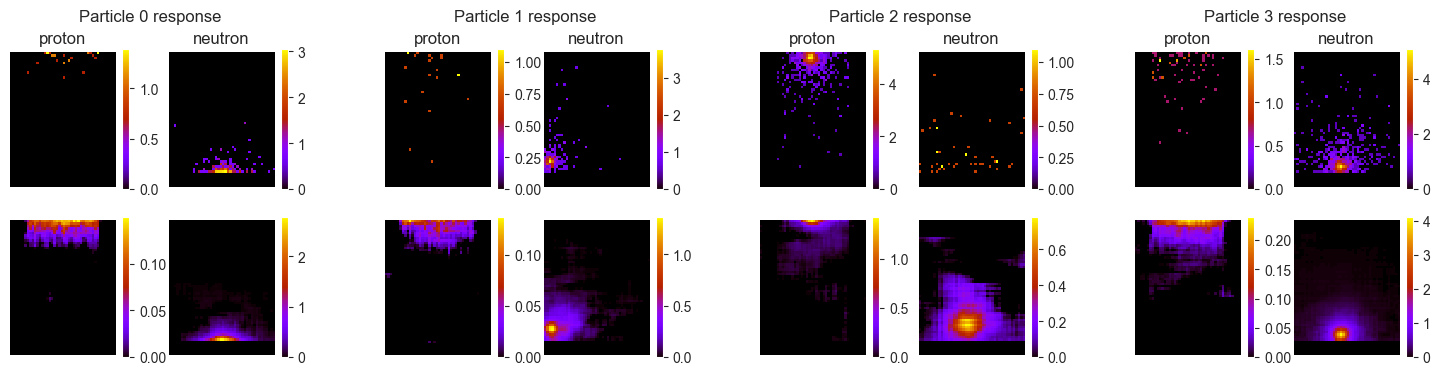

206/206 [==============================] - 2s 11ms/step
ws mean 37.78 ch1 29.32 ch2 27.29 ch3 13.70 ch4 9.23 ch5 109.35 Time for epoch 24 is 42.78249764442444 sec
5000 [Total loss: 73.27] [Recon_loss: 72.29] [KL loss: 1.41]


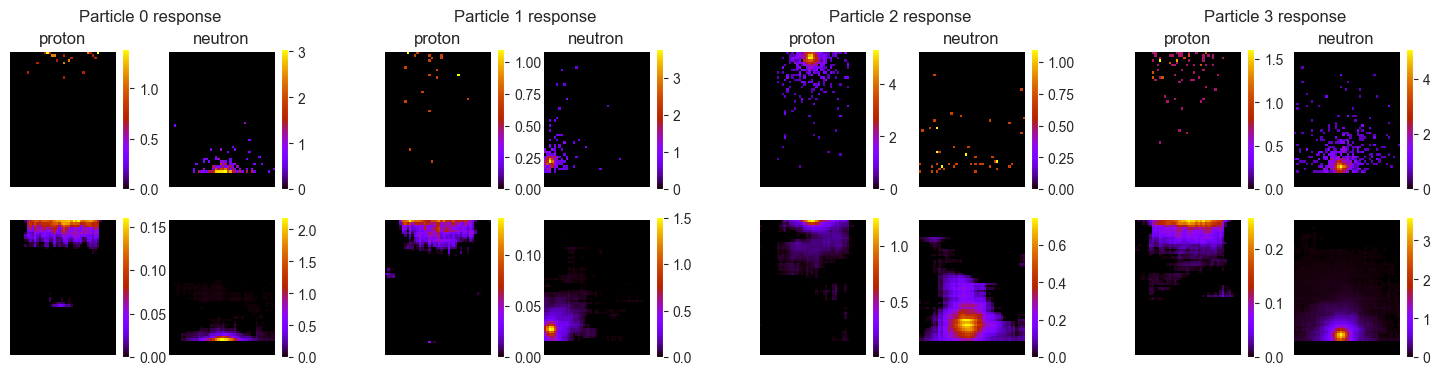

5100 [Total loss: 74.58] [Recon_loss: 73.59] [KL loss: 1.41]


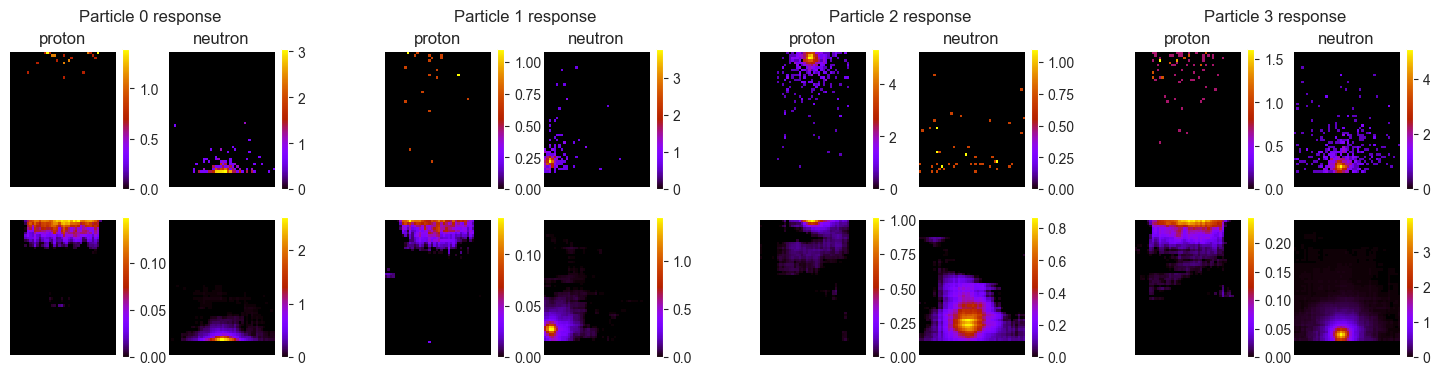

206/206 [==============================] - 2s 11ms/step
ws mean 46.42 ch1 38.22 ch2 30.71 ch3 18.94 ch4 10.70 ch5 133.51 Time for epoch 25 is 48.765504360198975 sec
5200 [Total loss: 74.16] [Recon_loss: 72.96] [KL loss: 1.71]
5300 [Total loss: 76.25] [Recon_loss: 74.95] [KL loss: 1.85]


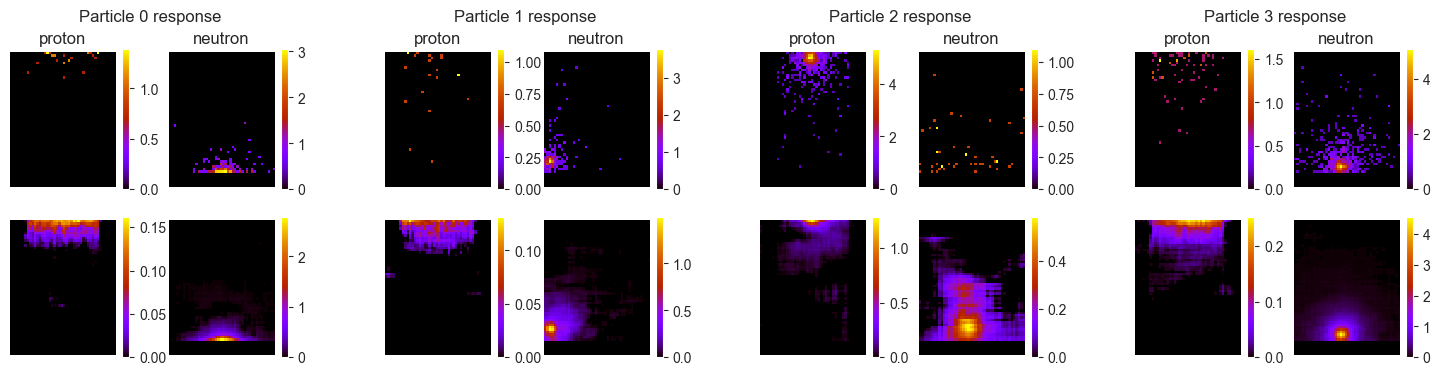

206/206 [==============================] - 2s 11ms/step
ws mean 30.98 ch1 24.71 ch2 21.91 ch3 13.10 ch4 8.60 ch5 86.56 Time for epoch 26 is 42.79903841018677 sec
5400 [Total loss: 75.94] [Recon_loss: 75.06] [KL loss: 1.26]
5500 [Total loss: 74.96] [Recon_loss: 73.79] [KL loss: 1.68]


206/206 [==============================] - 2s 11ms/step
ws mean 41.73 ch1 30.73 ch2 30.09 ch3 15.45 ch4 9.79 ch5 122.59 Time for epoch 27 is 43.538227796554565 sec
5600 [Total loss: 73.94] [Recon_loss: 72.84] [KL loss: 1.57]
5700 [Total loss: 72.20] [Recon_loss: 71.49] [KL loss: 1.01]


206/206 [==============================] - 2s 11ms/step
ws mean 41.17 ch1 31.77 ch2 29.16 ch3 16.02 ch4 10.12 ch5 118.79 Time for epoch 28 is 42.85406756401062 sec
5800 [Total loss: 74.81] [Recon_loss: 73.95] [KL loss: 1.22]
5900 [Total loss: 71.76] [Recon_loss: 71.02] [KL loss: 1.05]


206/206 [==============================] - 2s 11ms/step
ws mean 35.45 ch1 24.08 ch2 27.23 ch3 13.67 ch4 8.72 ch5 103.53 Time for epoch 29 is 43.40356111526489 sec
6000 [Total loss: 71.48] [Recon_loss: 70.63] [KL loss: 1.21]


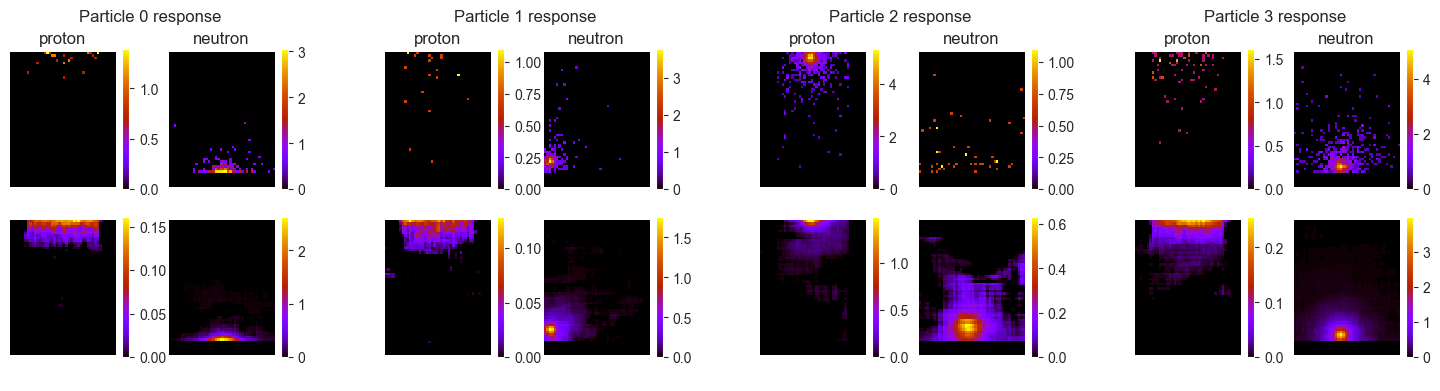

6100 [Total loss: 77.80] [Recon_loss: 77.04] [KL loss: 1.08]


206/206 [==============================] - 2s 11ms/step
ws mean 31.19 ch1 24.63 ch2 22.66 ch3 12.26 ch4 7.93 ch5 88.48 Time for epoch 30 is 48.87832283973694 sec
6200 [Total loss: 71.91] [Recon_loss: 71.14] [KL loss: 1.10]
6300 [Total loss: 74.30] [Recon_loss: 73.52] [KL loss: 1.11]


206/206 [==============================] - 2s 11ms/step
ws mean 29.02 ch1 19.21 ch2 23.59 ch3 11.06 ch4 8.18 ch5 83.06 Time for epoch 31 is 43.378129720687866 sec
6400 [Total loss: 72.53] [Recon_loss: 71.57] [KL loss: 1.37]
6500 [Total loss: 73.35] [Recon_loss: 72.31] [KL loss: 1.49]


206/206 [==============================] - 2s 11ms/step
ws mean 26.18 ch1 16.76 ch2 22.88 ch3 10.91 ch4 7.72 ch5 72.62 Time for epoch 32 is 42.47539973258972 sec
6600 [Total loss: 71.05] [Recon_loss: 70.05] [KL loss: 1.42]
6700 [Total loss: 72.11] [Recon_loss: 71.18] [KL loss: 1.33]


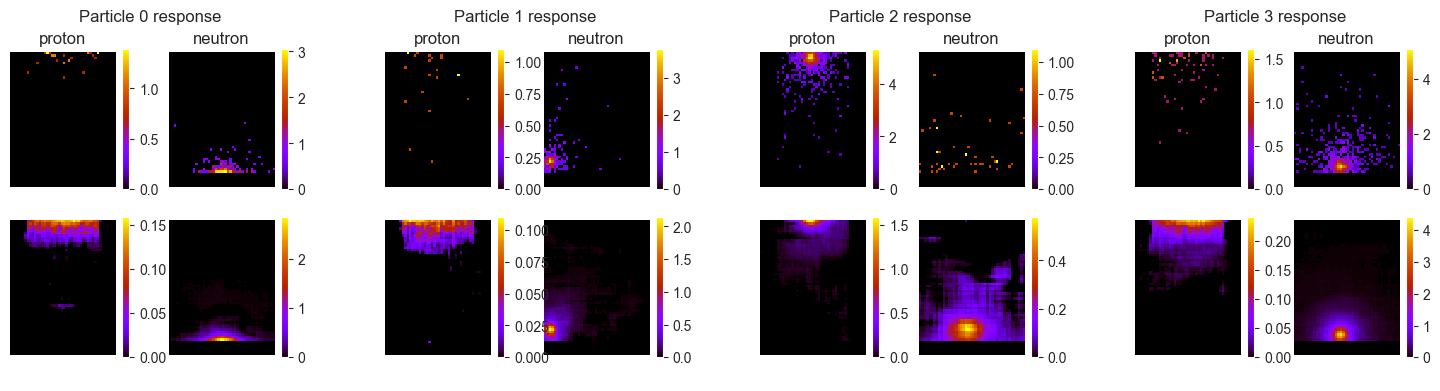

206/206 [==============================] - 2s 11ms/step
ws mean 29.46 ch1 18.68 ch2 24.46 ch3 11.07 ch4 8.39 ch5 84.67 Time for epoch 33 is 42.30486726760864 sec
6800 [Total loss: 72.91] [Recon_loss: 71.87] [KL loss: 1.49]
6900 [Total loss: 74.84] [Recon_loss: 74.16] [KL loss: 0.97]
7000 [Total loss: 76.57] [Recon_loss: 76.04] [KL loss: 0.75]


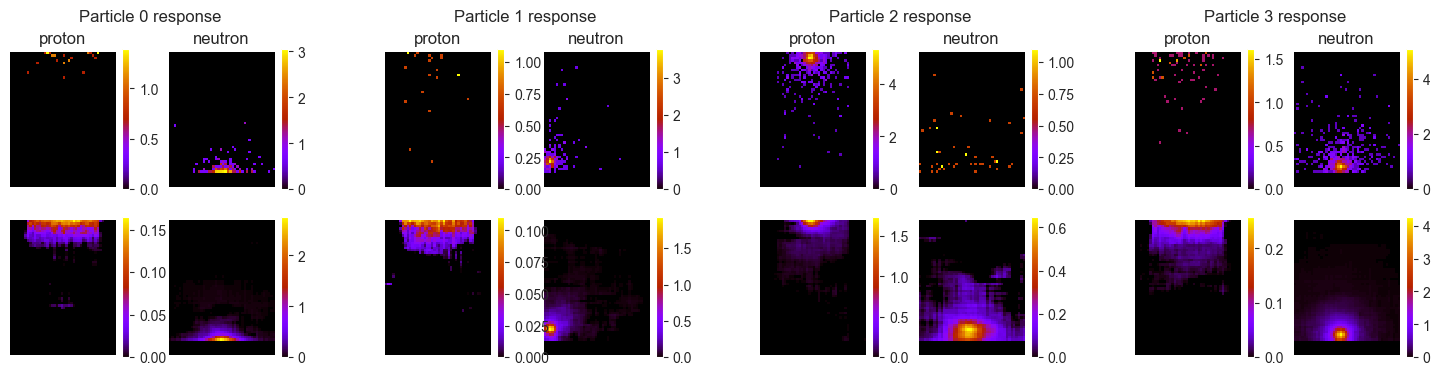

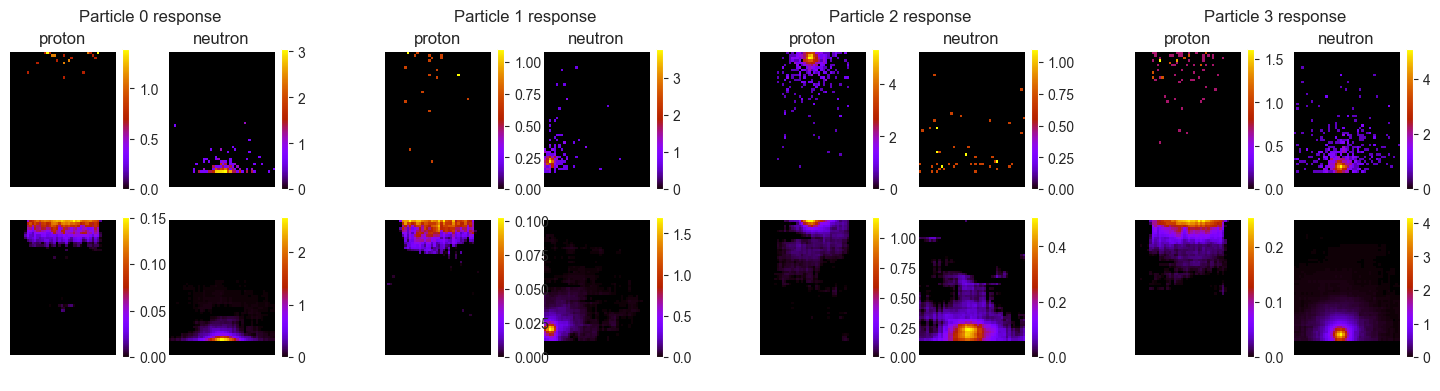

206/206 [==============================] - 2s 11ms/step
ws mean 39.70 ch1 29.40 ch2 29.70 ch3 16.31 ch4 9.80 ch5 113.27 Time for epoch 34 is 48.042359352111816 sec
7100 [Total loss: 73.61] [Recon_loss: 72.69] [KL loss: 1.31]
7200 [Total loss: 76.87] [Recon_loss: 75.79] [KL loss: 1.55]


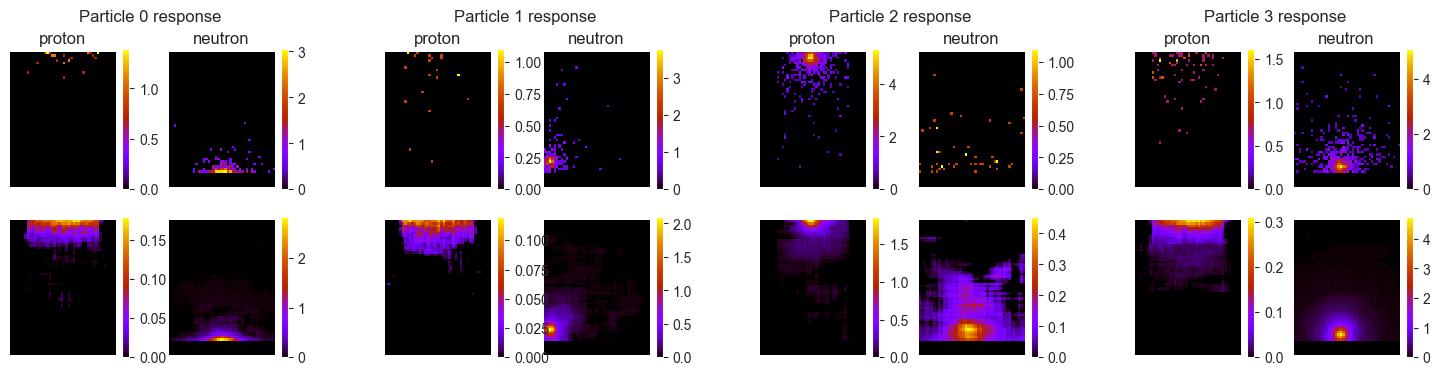

206/206 [==============================] - 2s 11ms/step
ws mean 19.68 ch1 11.25 ch2 19.41 ch3 8.57 ch4 6.42 ch5 52.73 Time for epoch 35 is 42.87430810928345 sec
7300 [Total loss: 73.45] [Recon_loss: 72.68] [KL loss: 1.09]
7400 [Total loss: 70.18] [Recon_loss: 69.35] [KL loss: 1.18]


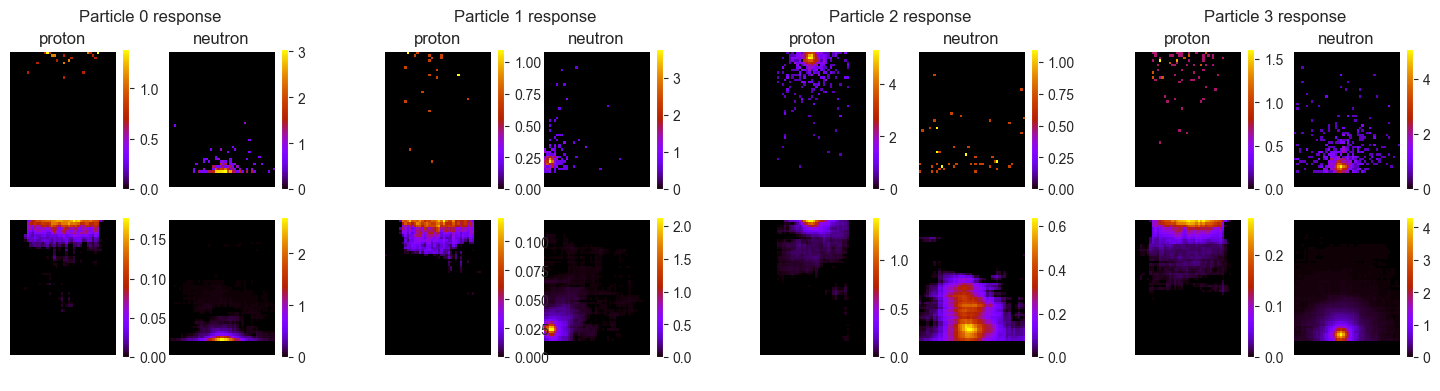

206/206 [==============================] - 2s 11ms/step
ws mean 25.57 ch1 16.47 ch2 20.84 ch3 11.73 ch4 7.30 ch5 71.52 Time for epoch 36 is 42.98083806037903 sec
7500 [Total loss: 75.77] [Recon_loss: 75.32] [KL loss: 0.65]
7600 [Total loss: 73.88] [Recon_loss: 73.29] [KL loss: 0.85]


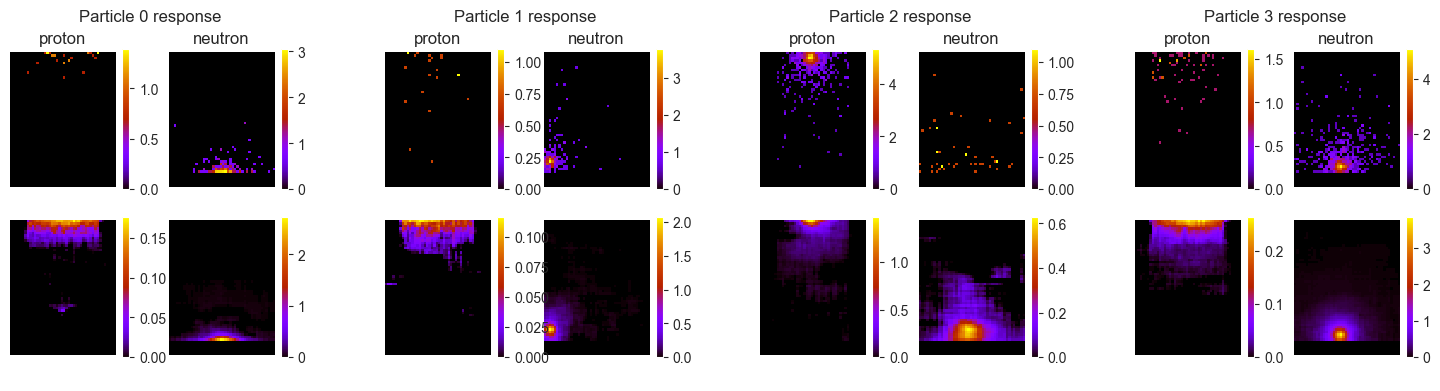

131/206 [==================>...........] - ETA: 0s

In [15]:
def calculate_ws_ch(n_calc):
    ws= [0,0,0,0,0]
    for j in range(n_calc):
        z = np.random.normal(0,1,(x_test.shape[0],10))
        z_c = y_test
        results = generator.predict([z,z_c])
        results = np.exp(results)-1
        try:
            ch_gen = np.array(results).reshape(-1,56,44)
            ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
            for i in range(5):
                ws[i] = ws[i] + wasserstein_distance(ch_org[:,i], ch_gen[:,i])
            ws =np.array(ws)
        except ValueError as e:
            print(e)

    ws = ws/n_calc
    print("ws mean",f'{ws.sum()/5:.2f}', end=" ")
    for n,score in enumerate(ws):
        print("ch"+str(n+1),f'{score:.2f}',end=" ")



####################### training ##############################
@tf.function
def train_step(batch,step):

    images, cond = batch
    step=step
    BATCH_SIZE = tf.shape(images)[0]

    #train vae
    with tf.GradientTape() as tape:
        z_mean, z_log_var, z = encoder([images, cond])
        reconstruction = generator([z, cond])
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.mean_squared_error(tf.reshape(images,(-1,56,44,2)), reconstruction), axis=(1, 2)
            )
        )
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = 0.7 * kl_loss + reconstruction_loss
    grads = tape.gradient(total_loss, generator.trainable_weights+encoder.trainable_weights)
    vae_optimizer.apply_gradients(zip(grads, generator.trainable_weights+encoder.trainable_weights))

    return total_loss, reconstruction_loss, kl_loss


history = []
def train(dataset, epochs):
    tf_step =tf.Variable(0, dtype=float)
    step=0
    generate_and_save_images(generator,
                           epochs,
                           [seed, seed_cond])

    for epoch in range(epochs):
        start = time.time()

        for batch in dataset:
            total_loss, reconstruction_loss, kl_loss =train_step(batch,tf_step)
            history.append([total_loss, reconstruction_loss, kl_loss])
            tf_step.assign_add(1)
            step = step+1

            if step%100==0:
                print("%d [Total loss: %.2f] [Recon_loss: %.2f] [KL loss: %.2f]"% (
                    step, total_loss, reconstruction_loss, kl_loss))

            if step%1000==0:
                generate_and_save_images(generator,
                               epochs,
                               [seed, seed_cond])

        generate_and_save_images(generator,
                                 epoch + 1,
                                 [seed, seed_cond]
                                 )

        # # Save the model every epoch
        # encoder.save_weights("../models/enc_"+NAME + "_"+ str(epoch) +".h5")
        # generator.save_weights("../models/gen_"+NAME + "_"+ str(epoch) +".h5")
        # np.savez("../models/history_"+NAME+".npz",np.array(history))

        calculate_ws_ch(min(epoch//5+1,5))

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    return history


"""
    fig = plt.figure(figsize=(15, 4), constrained_layout=True)
    outer = gridspec.GridSpec(1, 4, wspace=0.2, hspace=0.2, figure=fig)

    for i in range(4):
        inner = gridspec.GridSpecFromSubplotSpec(2, 2,
                                                 subplot_spec=outer[i], wspace=0.1, hspace=0.1)

        for j in range(4):
            ax = plt.Subplot(fig, inner[j])
            ax.set_axis_off()
            if i < 2:
                x = x_test[20+i][:,:,0].reshape(56,44)
            else:
                x = predictions[i-7].numpy()[:,:,1].reshape(56,44)

            im = ax.imshow(x,interpolation='none', cmap='gnuplot')
            fig.colorbar(im, ax=ax)
            # t = ax.text(0.5,0.5, 'outer=%d, inner=%d' % (i, j))
            fig.add_subplot(ax)
            # ax.axis('off')
"""

create_dir(os.path.join("../images/", EXPERIMENT_NAME))

def generate_and_save_images(model, epoch, test_input):
    START_INDEX = 0

    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    """
    predictions has shape (n_samples, 56, 44, 2). First channel has proton data, second has neutrons
    """
    fig = plt.figure(figsize=(15,4))

    plt.title(f"EPOCH {epoch}")

    subfigs = fig.subfigures(1, 4)

    for particle_num, subfig in enumerate(subfigs.flat):  # iterate over 4 particles
        subfig.suptitle(f'Particle {particle_num} response')
        axs = subfig.subplots(2, 2)
        for i, ax in enumerate(axs.flat):  # iterate over 4 images of single particle
            m_2 = i % 2  # 0 if proton, 1 if neutron
            if i < 2:
                # Real response
                x = x_test[START_INDEX+particle_num][:,:,m_2].reshape(56,44)
                axs[i//2, m_2].set_title("neutron" if m_2 else "proton")
            else:
                # Generated response
                x = predictions[START_INDEX+particle_num].numpy()[:,:,m_2].reshape(56,44)
            axs[i//2, m_2].set_axis_off()
            im = axs[i//2, m_2].imshow(x, interpolation='none', cmap='gnuplot')
            fig.colorbar(im, ax=axs[i//2, m_2])

            # t = ax.text(0.5,0.5, 'outer=%d, inner=%d' % (i, j))
            # fig.add_subplot(ax)
            # ax.axis('off')
    # fig.suptitle(f"Epoch: {epoch}")
    # for i in range(0,14):
    #     if i < 7:
    #         x = x_test[20+i][:,:,:1].reshape(56,44)
    #     else:
    #         x = predictions[i-7].numpy()[:,:,:1].reshape(56,44)
    #     #x[x<=0]=x.max()*-0.1
    #     im = axs[i//7,i%7].imshow(x,interpolation='none', cmap='gnuplot')
    #     axs[i//7,i%7].axis('off')
    #     fig.colorbar(im, ax=axs[i//7,i%7])
    plt.savefig(f'../images/{EXPERIMENT_NAME}/image_at_epoch_{epoch}.png')
    plt.show()

# ### Train model
history=train(dataset_with_cond, EPOCHS)

### Visualize losses

In [40]:
import seaborn as sns

sns.set_context('notebook', font_scale = 1)

In [41]:
# total_loss, reconstruction_loss, kl_loss
history_losses = np.array([[float(loss) for loss in losses] for losses in history])

In [42]:
total_loss = history_losses[:,0]
reconstruction_loss = history_losses[:,1]
kl_loss = history_losses[:,2]

In [16]:
a4_dims = (14, 5)
def print_loss(loss_values, loss_str):
    fig, ax = plt.subplots(figsize=a4_dims)
    sns.lineplot(loss_values)
    plt.xscale('log')
    ax.set_title(f"{loss_str} loss in each epoch")
    ax.set_xlabel("Epoch number")
    ax.set_ylabel(f"{loss_str} loss value")
    fig.save(f"../images/{EXPERIMENT_NAME}/{loss_str}_loss")

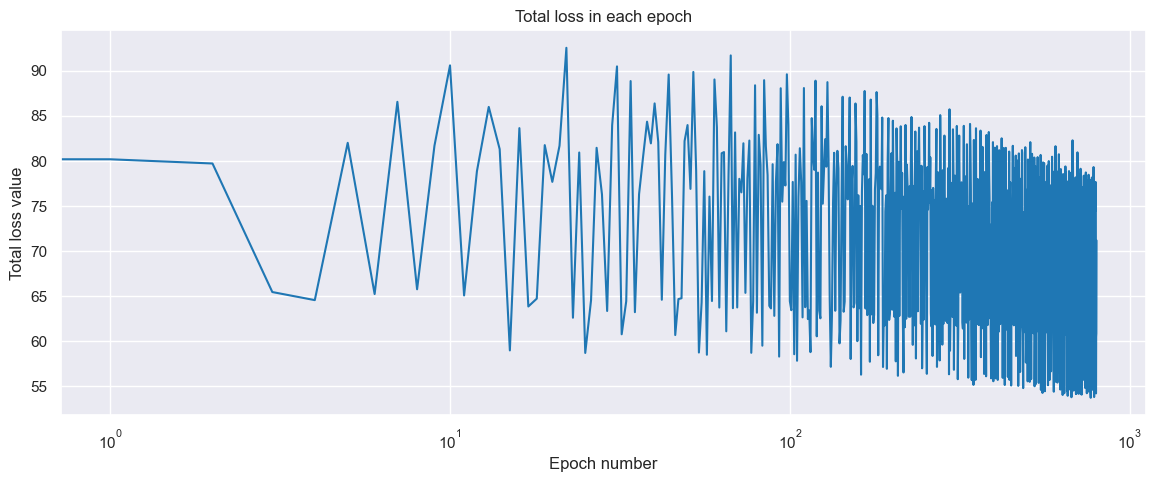

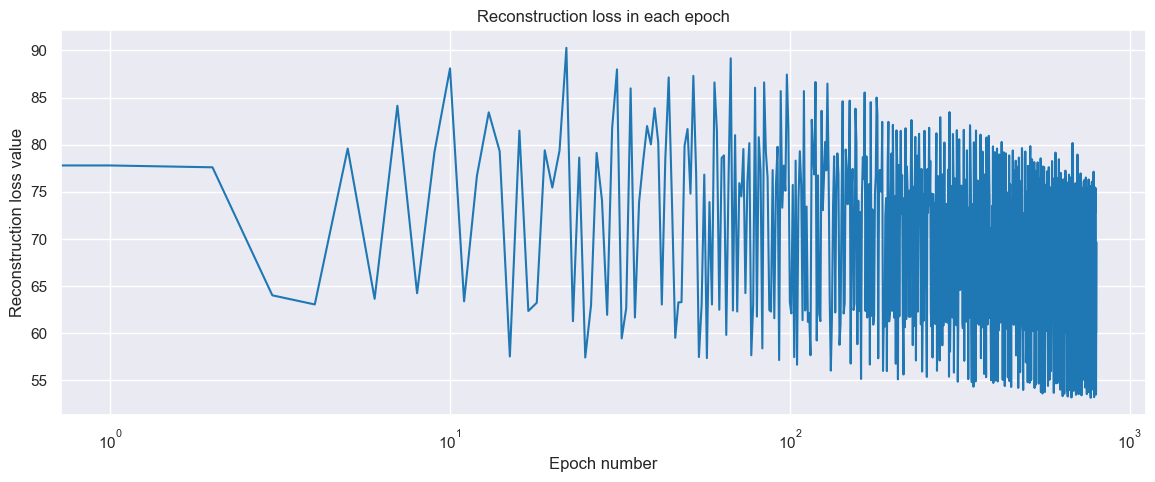

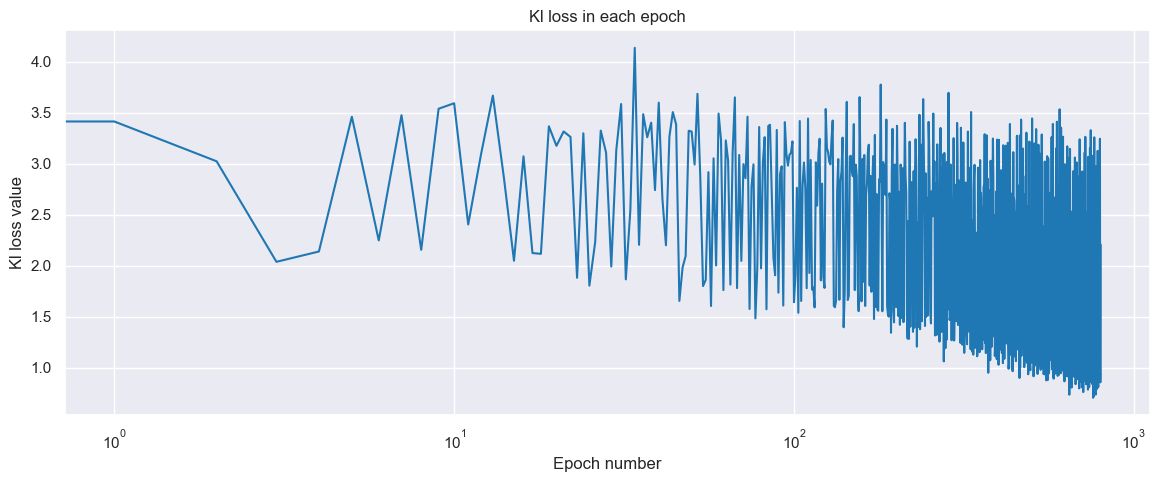

In [44]:
print_loss(total_loss, "Total")
print_loss(reconstruction_loss, "Reconstruction")
print_loss(kl_loss, "Kl")